In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ops.mplstyle')
import tensorflow as tf
import gpflow

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['lines.linewidth'] = 3

# Classification with sparse GPs

### James Hensman

### October 2017

This notebook serves as a tutorial: the aim is to understand how GP classification with sparse approximations work in GPflow.

First, let's have a look at the illustrative dataset from the lecture. Here's how it was generated:

(-1.5, 2.5)

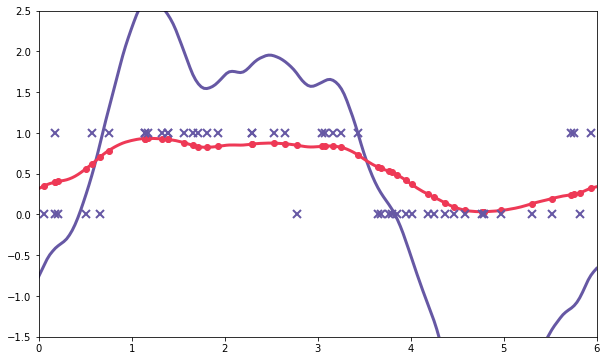

In [2]:
# Draw a sample from a GP

# first build the kernel and kernel matrix
k = gpflow.kernels.Matern52(1, variance=6.0)
X_all = np.linspace(0, 6, 200).reshape(-1, 1)
K = k.compute_K_symm(X_all)

# sample from a multivariate normal
L = np.linalg.cholesky(K)
f_all = np.dot(L, np.random.RandomState(6).randn(200, 1))
plt.plot(X_all, f_all, 'C0')

# squash
p_all = np.exp(f_all) / (1 + np.exp(f_all))
plt.plot(X_all, p_all, 'C3')

# evaluate a small number of points
ind = np.random.randint(0, 200, (50,))
X = X_all[ind]
p = p_all[ind]
plt.plot(X, p, 'C3o', ms=6)


# bernoulli draws
Y = np.where(np.random.rand(50, 1) < p, 1, 0)
plt.plot(X, Y, 'C0x', ms=8, mew=2)

plt.xlim(0, 6)
plt.ylim(-1.5, 2.5)

### Exercise 1: the effect of the parameters on classification datasets

a) Change the variance parameter in the kernel above (try 100, 0.01). What is the effect on the data X, Y ?

b) What is the effect of the lengthscale parameter on X and Y?

Now let's build a GPflow model of these data.

In [3]:
# here's a GPflow model. it assumes that the inducing locations Z are fixed to the data X.
# We'll tell the model that the data are Binary (Bernoulli likelihood), and we'll pick a kernel.
m = gpflow.models.SVGP(X, Y,
                      likelihood=gpflow.likelihoods.Bernoulli(),
                      kern=gpflow.kernels.Matern52(1),
                      Z=X.copy())
m.Z.set_trainable(False)

o = gpflow.train.ScipyOptimizer()
o.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22.418716
  Number of iterations: 42
  Number of functions evaluations: 45


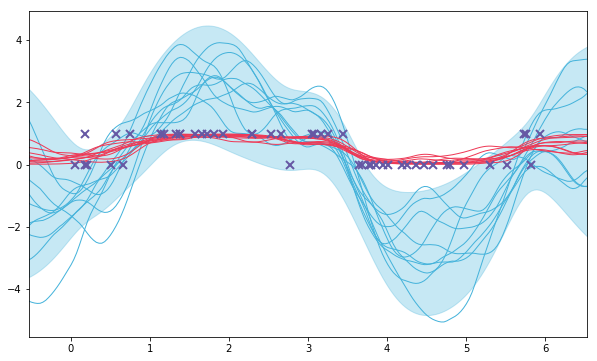

In [4]:
def plot_1d(m):
    # work out some sensible limits
    xmin, xmax = m.X.read_value().min(), m.X.read_value().max()
    xmin, xmax = xmin - 0.1 * (xmax - xmin), xmax + 0.1 * (xmax - xmin)
    Xtest = np.linspace(xmin, xmax, 200).reshape(-1, 1)
    
    # bubble fill the predictions
    mu, var = m.predict_f(Xtest)
    plt.fill_between(Xtest.flatten(),
                     (mu + 2 * np.sqrt(var)).flatten(),
                     (mu - 2 * np.sqrt(var)).flatten(),
                     alpha=0.3, color='C1')
    
    # plot samples
    samples = m.predict_f_samples(Xtest, 10).squeeze()
    plt.plot(Xtest, samples.T, 'C1', lw=1)
    
    # plot p-samples
    p = np.exp(samples) / (1. + np.exp(samples))
    plt.plot(Xtest, p.T, 'C3', lw=1)

    # plot data
    plt.plot(m.X.read_value(), m.Y.read_value(), 'C0x', ms=8, mew=2)
    
    plt.xlim(xmin, xmax)

plot_1d(m)

Okay, now we have a model of your dataset. Let's poke the model and see if we can understand how it works. 

### Exercise 2: poke the model

a) Print the model. Can you relate the parameters to the variables discussed in the lecture?

b) After optimizing the model, has the model managed to estimate the kernel parameters effectively? 

c) Since we know what the optimal kernel parameters are, let's see how the model works with those. Assign the known kernel parameters to the model and mark them as not for training (`m.kern.foo.set_trainable(False)`). You will have to optimize the model again. Are these parameters better than the estimated ones? 

In [5]:
# your answers here.

## Classification in 2D

It's straightforward to move the GP classification problem into 2D by simply changing the kernel. We'll do that here, and in addition relax the assumption that X=Z. 

In [6]:
# here's a standard 2D dataset.
X_banana = np.loadtxt('banana_X_train', delimiter=',')
Y_banana = np.loadtxt('banana_Y_train', delimiter=',').reshape(-1, 1)

In [7]:
# here's the sparse GP model:
m = gpflow.models.SVGP(X_banana, Y_banana,
                       kern=gpflow.kernels.Matern52(2),
                       likelihood=gpflow.likelihoods.Bernoulli(),
                       Z=np.random.rand(8, 2))

In [1]:
# and here's a function for plotting the model
def plot_2d(m):
    sess = m.enquire_session(None)
    #plot the inducing point locations:
    if hasattr(m, 'Z'):
        Z = m.Z.read_value(sess)
        plt.plot(Z[:, 0], Z[:, 1], 'C3o', ms=10, label="inducing")
    
    xmin, ymin = m.X.read_value(sess).min(0)
    xmax, ymax = m.X.read_value(sess).max(0)
    xmin, xmax = xmin - 0.1 * (xmax - xmin), xmax + 0.1 * (xmax - xmin)
    ymin, ymax = ymin - 0.1 * (ymax - ymin), ymax + 0.1 * (ymax - ymin)
    
    xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    Xtest = np.vstack([xx.flatten(), yy.flatten()]).T
    mu, var = m.predict_y(Xtest)
    
    X, Y = m.X.read_value(sess), m.Y.read_value(sess)
    
    for i, level in [[0, 0.2], [1, 0.8]]:
        plt.plot(X[Y.flatten()==i, 0], X[Y.flatten()==i, 1], 'C{}o'.format(i), ms=8, label='y={}'.format(i))
        cs = plt.contour(xx, yy, mu.reshape(*xx.shape), [level], colors='C{}'.format(i), linewidths=3)
        cs.collections[0].set_label('p(y={}) = {}'.format(i, level))
                         
    cs = plt.contour(xx, yy, mu.reshape(*xx.shape), [0.5], colors='C3', linewidths=1)
    cs.collections[0].set_label('p(y=1) = 0.5')
    
    plt.legend(loc=0)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)


### Exercise 3: understanding the model

a) Use the above function to plot the model. What's going on in the plot? 

b) Okay, optimize the model (perhaps borrow the code from the 1D model above). Plot again. Better? 

c) How do the lines in the plots correspond to our distribution on functions?

d) Investigate the effect of the *number* of the inducing input points. Try the model with 4, 12, 20, 200 rows in Z.
Plot each: what happens?

e) Investigate the effect of the *locations* of the inducing points. Does it work if you initialize them far away from the model? What does the model do if you refuse to let it adapt Z (`m.Z.set_trainable(False)`)? 

bonus) Initialize the model with Z = np.zeros((10, 2)). What happens and why?

In [21]:
# Your answers here!

## Active learning

Here's a setup: there's a stochastic process, which takes an action (a 2D vector $\in [0, 1]^2$), and returns a reward (1 or 0). Your goal is to maximize the probability of getting a reward of 1 on the 51st interaction with the Bandit.

Below we have implemented a random policy to get you started:

In [22]:
from gp_bandit import Bandit

def run_random_policy():
    # make a fresh bandit
    my_bandit = Bandit()
    

    actions = []
    rewards = []
    
    for i in range(50):
        a = np.random.rand(2) # random policy
        r = my_bandit(a)

        #log
        actions.append(a)
        rewards.append(r)
    
    #plot what's going on
    plt.plot(rewards)
    plt.xlabel('t')
    plt.ylabel('reward')
    
    #get the 51st reward
    a51 = np.random.randn(2)  # random policy
    r51 = my_bandit(a)
    
    print('the final reward was', r51)


the final reward was 1


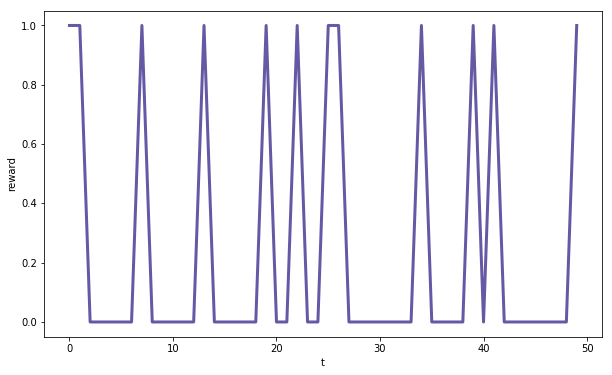

In [23]:
run_random_policy()

It should be clear in the above code that the algorithm isn't doing any learning. Next, we'll implement an Agent that maintains a GP model of the Bandit, and attempts to actively learn what to do next.

First, we'll make a simple GP model like the one above that can have adaptive data (`updatable_model`). Then, we'll define a simple Agent class that greedily selects the next point.

In [24]:
def updatable_model(actions, rewards):
    # construct a GP model with variables for X and Y so we can increment the data
    X = np.vstack(actions)
    Y = np.vstack(rewards).reshape(-1, 1)
    X_ = tf.Variable(X, dtype=tf.float64, validate_shape=False, trainable=False)
    Y_ = tf.Variable(Y, dtype=tf.float64, validate_shape=False, trainable=False)
    num_data = tf.Variable(X.shape[0], dtype=tf.int32, trainable=False)
    m = gpflow.models.SVGP(X_, Y_,
                       kern=gpflow.kernels.Matern52(2, lengthscales=0.5),
                       likelihood=gpflow.likelihoods.Bernoulli(),
                       Z=np.random.rand(8, 2),
                       num_data=num_data, num_latent=1)
    m.kern.lengthscales.set_trainable(False)
    sess = m.enquire_session(None)
    
    sess.run([m.X.parameter_tensor.initializer,
                   m.Y.parameter_tensor.initializer,
                   m.num_data.initializer])
    # slow but accurate optimizer:
    # opt = gpflow.train.ScipyOptimizer(options=dict(maxiter=10))
    
    # quick and nasty optimizer
    opt = gpflow.train.AdamOptimizer(0.05)
    opt.minimize(m, maxiter=200)
    return m, opt

def update_model(m, actions, rewards):
    # update the data in the model with the latent actions and rewards
    X = np.vstack(actions)
    Y = np.vstack(rewards).reshape(-1, 1)
    sess = m.enquire_session(None)
    sess.run(tf.assign(m.X.parameter_tensor, X, validate_shape=False))
    sess.run(tf.assign(m.Y.parameter_tensor, Y, validate_shape=False))
    sess.run(tf.assign(m.num_data, X.shape[0]))

class GreedyAgent(object):
    def __init__(self, actions, rewards):
        self.m, self.opt = updatable_model(actions, rewards)
    
    def policy(self, actions, rewards):
        """from a history of actions and rewards, return a new action."""
        
        # update the GP with the latest set of actions and rewards
        update_model(self.m, actions, rewards)
        self.opt.minimize(self.m, maxiter=100)

        # a big array of potential actions
        potential_actions = np.random.rand(1000, 2)

        # pick the best action
        p, _ = self.m.predict_y(potential_actions)    
        i = np.argmax(p.flatten())

        self.plot(potential_actions)

        return potential_actions[i, :]

    def plot(self, potential_actions):
        p, _ = self.m.predict_y(potential_actions)
        plt.figure()
        plt.scatter(potential_actions[:, 0], potential_actions[:, 1], 10, p.flatten(), lw=0)
        plt.colorbar()
        plot_2d(self.m)
        plt.xlim(0, 1)
        plt.ylim(0, 1)

Phew, that was a lot of code. If only someone could develop some kind of platform for all this...

Let's see how the greedy agent deals with the same problem.

In [25]:
def run_greedy_policy():
    # make a fresh bandit
    my_bandit = Bandit()
    
    actions = []
    rewards = []
    
    # run a random policy for 10 iterations
    [actions.append(np.random.rand(2)) for i in range(10)]
    [rewards.append(my_bandit(a)) for a in actions]
    
    my_agent = GreedyAgent(actions, rewards)
    
    # go!
    for i in range(10, 20):
        a = my_agent.policy(actions, rewards)
        
        r = my_bandit(a)

        #log
        actions.append(a)
        rewards.append(r)
    
    #plot what's going on
    plt.figure()
    plt.plot(rewards)
    plt.xlabel('t')
    plt.ylabel('reward')
    
    #get the 51st reward
    a51 = my_agent.policy(actions, rewards)
    r51 = my_bandit(a51)
    
    print('the final reward was', r51)

/home/nicolas/python/venv/gpflow_new/lib/python3.5/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


the final reward was 1


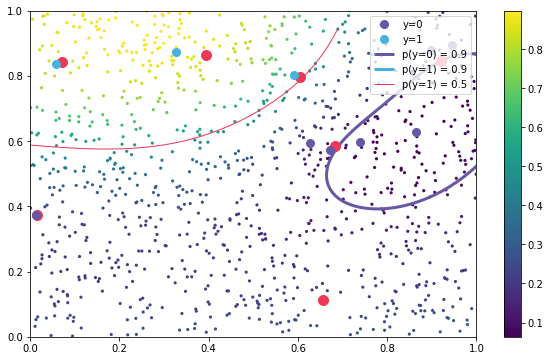

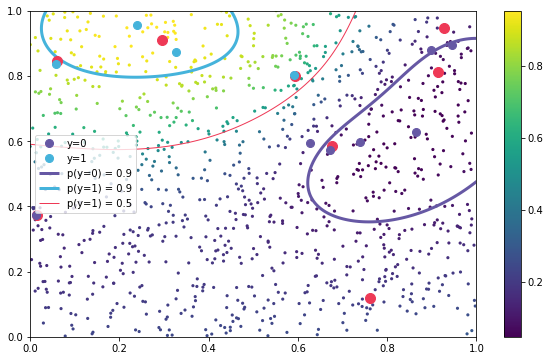

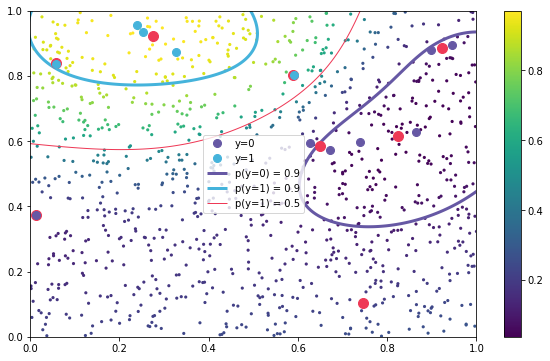

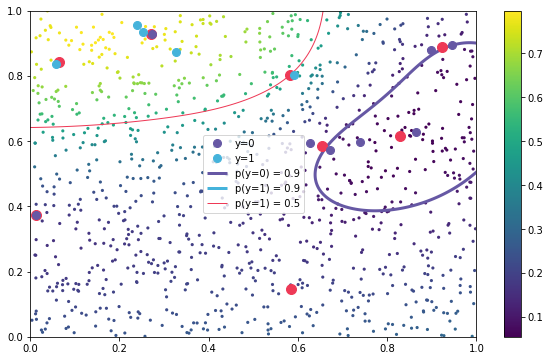

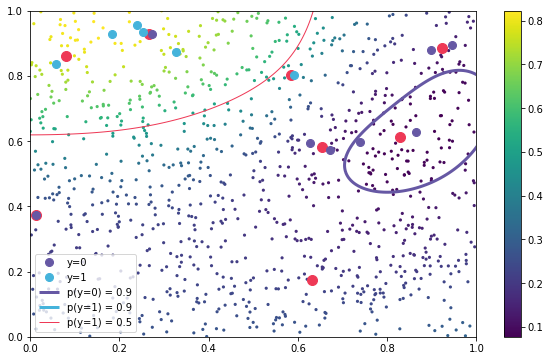

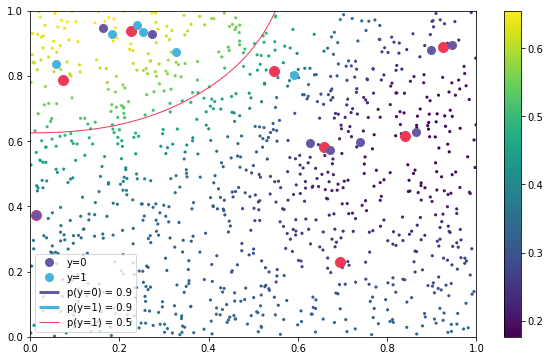

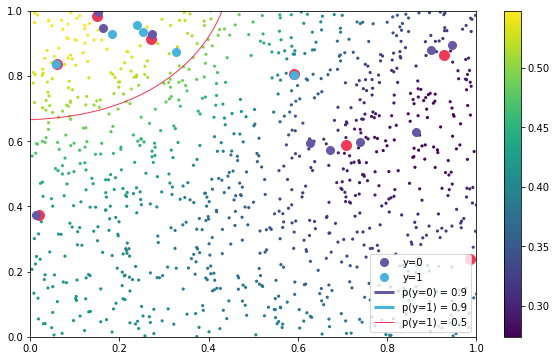

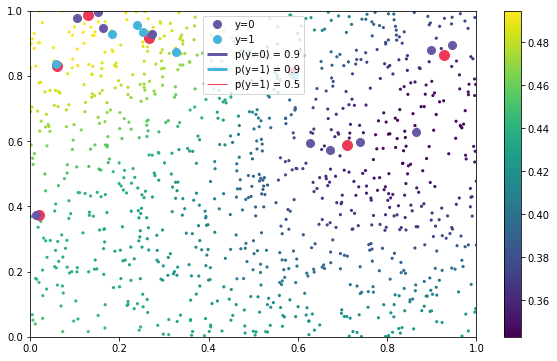

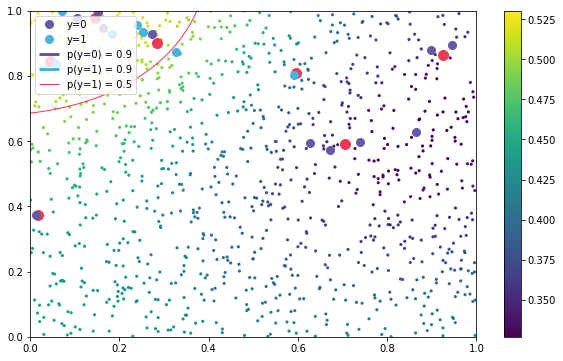

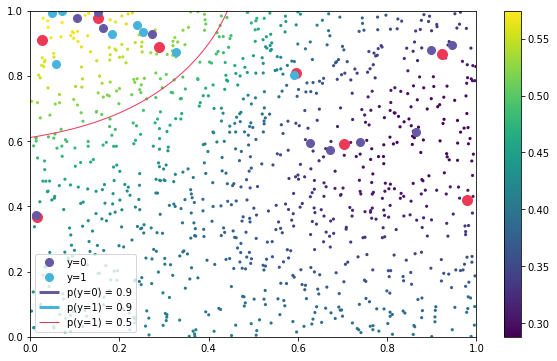

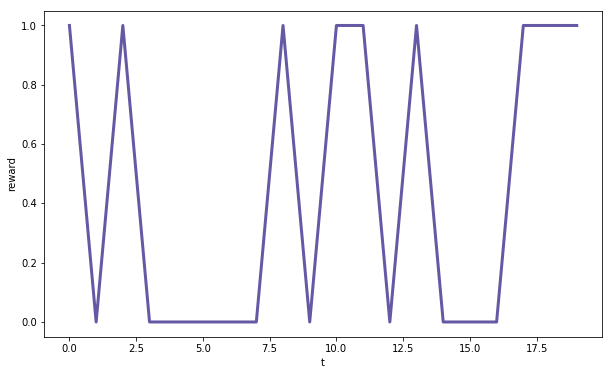

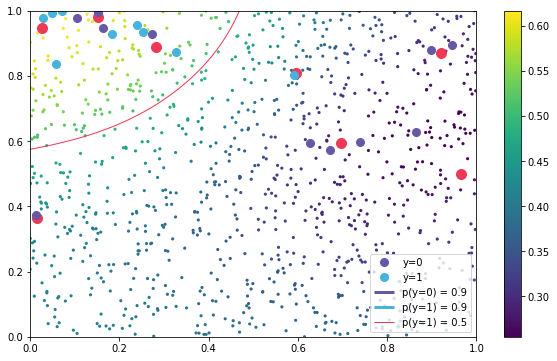

In [26]:
run_greedy_policy()

### Exercise 3.

a) Are you able to interpret what's happening in the above series of plots? What is represented by

i) the big purple/blue dots?
  
ii) the solid lines?

iii) the small dots and their colours?

iv) the red dots?

b) Is the agent doing a good job of balancing exploration and exploitation? Can you write a better policy using the same model?